# Master overview
This master overview contains all graphs used in the final thesis, to make sure everything was trained and tested on the same data.

In [30]:
# utils
from util import evaluate_no_cv, calculate_auc_and_plot, get_epitope_df, get_features, fix_test, \
    evaluate_seperate_chains, get_columns_starting_with, get_counts

# sklearn
from sklearn.model_selection import train_test_split
from sklearn import impute
from sklearn.pipeline import Pipeline

# other
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# models
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

# warnings
import warnings

warnings.filterwarnings("ignore",
                        category=UserWarning)  # hide: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
warnings.filterwarnings("ignore", category=FutureWarning)

In [31]:
models_to_evaluate = []

In [32]:
# train/test data
folds = 5
epitope = "GILGFVFTL"
species = "HomoSapiens"
df = get_epitope_df(epitope, species=species)
df = df.sample(500)

data_per_fold = []
for seed in range(folds):
    fold_data = {"seed": seed,
                 "epitope": epitope,
                 "species": species}

    train_with_nan, test_with_nan = train_test_split(df, test_size=0.2, random_state=seed)

    test = test_with_nan.dropna()

    x_missing = train_with_nan.isna().any(axis=1)

    # with nan in train set
    x = get_features(train_with_nan)
    x.fillna(0, inplace=True)  # Nan's introduced by get_features
    y = train_with_nan['reaction']

    x_missing_test = test_with_nan.isna().any(axis=1)
    x_test = get_features(test, test=True)
    x_test = fix_test(x_test, x.columns)
    x_test.fillna(0, inplace=True)  # Nan's introduced by get_features
    y_test = test['reaction']

    alpha_only_count_pos, beta_only_count_pos, both_count_pos, non_count_pos = get_counts(train_with_nan)

    fold_data["nan"] = {"x": x, "y": y, "x_test": x_test, "y_test": y_test, 'x_missing': x_missing,
                        'x_missing_test': x_missing_test, 'x_original': train_with_nan,
                        'x_test_original': test,
                        "train_alpha_only": alpha_only_count_pos, "train_beta_only": beta_only_count_pos,
                        "train_both": both_count_pos, "train_non": non_count_pos, 'train_total': len(x),
                        'test_total': len(x_test)}

    # without nan in train set
    train_without_nan = train_with_nan.dropna()
    x = get_features(train_without_nan)
    x.fillna(0, inplace=True)  # Nan's introduced by get_features
    y = train_without_nan['reaction']

    x_test = get_features(test, test=True)
    x_test = fix_test(x_test, x.columns)
    x_test.fillna(0, inplace=True)  # Nan's introduced by get_features
    y_test = test['reaction']

    fold_data["no_nan"] = {"x": x, "y": y, "x_test": x_test, "y_test": y_test, 'train_total': len(x),
                           'test_total': len(x_test), 'train_both': len(train_without_nan), 'train_non': 0, 'x_original': train_without_nan, 'x_test_original': test,
                           'train_alpha_only': 0, 'train_beta_only': 0}

    data_per_fold.append(fold_data)

# print train and test size for seed 0 (nan and no_nan)
nan_data = data_per_fold[0]["nan"]
no_nan_data = data_per_fold[0]["no_nan"]
print(f"Nan: train: {len(nan_data['x'])}, test: {len(nan_data['x_test'])}")
print(f"No Nan: train: {len(no_nan_data['x'])}, test: {len(no_nan_data['x_test'])}")

C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


Number of negative samples changed from 47033 to 44205 (because of overlap with positive samples)
Positive samples: alpha only: 2580, beta only: 3056, both: 2194, none: 0
Negative samples (will be sampled to select same amount as positive): alpha only: 4499, beta only: 17510, both: 22196, none: 0
Nan: train: 400, test: 30
No Nan: train: 117, test: 30


In [33]:
def evaluate_model(model_description):
    """"
    model description is a dict with the following keys:
    - name*: name of the model
    - model*: the model
    - imputer: the imputer to use
    - chain: 'both', 'alpha', 'beta' or 'seperate'. In cas of 'seperate', model_alpha and model_beta must be defined instead of model
    - drop_train_na: if True, all rows with nan in the train set are dropped
    - missing_indicator: if True, a missing indicator is added as feature
    """
    global data_per_fold

    scores = pd.DataFrame()

    num_folds = len(data_per_fold)
    for i in range(num_folds):

        model_train_nan = not model_description.get("drop_train_na", False)
        data_name = "nan" if model_train_nan else "no_nan"

        chain = model_description.get("chain", "both")
        assert chain in ["both", "alpha", "beta", "seperate"]

        fold_data = data_per_fold[i]
        fold_dataset = fold_data[data_name]
        x = fold_dataset["x"].copy()
        y = fold_dataset["y"].copy()
        x_test = fold_dataset["x_test"].copy()
        y_test = fold_dataset["y_test"].copy()

        gene_features = model_description.get("gene_features", "FV")
        assert gene_features in ["FV", "F", "V", "F+V", "FV+F+V"] #, "CDR_only"]
        if gene_features != "FV":
            # recreate train data
            x_original = fold_dataset["x_original"]
            x_test_original = fold_dataset["x_test_original"]

            column_map = {'F': ['V_family', 'J_family'],
                          'V': ['V_version', 'J_version'],
                          'FV': ['V', 'J']}
            column_map['F+V'] = column_map['F'] + column_map['V']
            column_map['FV+F+V'] = column_map['FV'] + column_map['F'] + column_map['V']
            # add CDR3 to all
            for key in column_map:
                column_map[key].append('CDR3')

            columns_to_use = column_map[gene_features]

            x = get_features(x_original, columns=columns_to_use)
            x.fillna(0, inplace=True)

            x_test = get_features(x_test_original, columns=columns_to_use, test=True)
            x_test = fix_test(x_test, x.columns)
            x_test.fillna(0, inplace=True)


        missing_indicator = model_description.get("missing_indicator", False)
        if missing_indicator:
            x_missing = fold_dataset["x_missing"]
            x_missing_test = fold_dataset["x_missing_test"]
            x["missing"] = x_missing
            x_test["missing"] = x_missing_test

        if chain == "alpha" or chain == "beta":
            x = get_columns_starting_with(x, f'{chain}_')
            x_test = get_columns_starting_with(x_test, f'{chain}_')

        model_imputer = model_description.get("imputer", None)

        separate_chains = chain == "seperate"

        try:
            if separate_chains:
                model_alpha = model_description["model_alpha"]
                model_beta = model_description["model_beta"]
                auc = evaluate_seperate_chains(model_alpha, model_beta, x, y, x_test, y_test, model_imputer)
            else:
                model = model_description["model"]
                if model_imputer is not None:
                    model = Pipeline([('imputer', model_imputer), ('model', model)])
                    model_imputer = None
                auc = evaluate_no_cv(model, x, y, x_test, y_test, model_imputer)

            index = len(scores)
            scores.loc[index, 'model'] = model_description['name']
            scores.loc[index, 'auc'] = auc
            scores.loc[index, 'model_train_nan'] = model_train_nan
            scores.loc[index, 'imputer'] = model_imputer.__class__.__name__ if model_imputer is not None else None
            scores.loc[index, 'chain'] = chain

            scores.loc[index, 'seed'] = fold_data["seed"]
            scores.loc[index, 'epitope'] = fold_data["epitope"]
            scores.loc[index, 'species'] = fold_data["species"]

            scores.loc[index, 'train_alpha_only'] = fold_dataset["train_alpha_only"]
            scores.loc[index, 'train_beta_only'] = fold_dataset["train_beta_only"]
            scores.loc[index, 'train_both'] = fold_dataset["train_both"]
            scores.loc[index, 'train_non'] = fold_dataset["train_non"]
            scores.loc[index, 'train_total'] = fold_dataset["train_total"]
            scores.loc[index, 'test_total'] = fold_dataset["test_total"]

            scores.loc[index, 'gene_features'] = gene_features
            scores.loc[index, 'missing_indicator'] = missing_indicator

            # print the row
            # print(scores.loc[index])
            # print(f"AUC(m={model_description['name']}, s={seed}, train_na={int(model_train_nan)}): {auc}")
            print(auc)

        except Exception as e:
            print(f"Error: {e}")
            # raise e
            continue

    return scores

In [34]:
def evaluate_model_list(models_to_evaluate):
    start_time = datetime.now()

    scores = pd.DataFrame()
    for i, model in enumerate(models_to_evaluate):
        print(f"\nEvaluating model {i + 1}/{len(models_to_evaluate)}")
        print(model)
        model_scores = evaluate_model(model)
        scores = pd.concat([scores, model_scores])
    # write to csv
    end_time = datetime.now()
    time_taken = end_time - start_time
    timestamp = end_time.strftime("%Y%m%d-%H%M%S")
    scores.to_csv(f"outputs/scores-{timestamp}.csv")

    print(f'Finished evaluating {len(models_to_evaluate)} models at {timestamp} in {time_taken} seconds')

    return scores

In [35]:
def plot_scores(scores, plot_title, baseline_name="Random Forest (NaNs dropped in train)", hue=None):
    baseline = scores[(scores['model'] == baseline_name) & (scores['chain'] == 'both')]['auc'].mean()
    scores["improvement"] = scores["auc"] - baseline

    x_label_rotation = 90

    # plot starting at 0
    plot = sns.barplot(x="model", y="auc", data=scores, ci="sd", hue=hue)
    plot.set(title=plot_title)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=x_label_rotation)
    plt.show()
    plot.figure.clf()

    # plot showing improvement from baseline
    plot = sns.barplot(x="model", y="improvement", data=scores, ci="sd", hue=hue)
    plot.set(title=f"{plot_title} (improvement)")
    plot.set_xticklabels(plot.get_xticklabels(), rotation=x_label_rotation)

    plot.axhline(0, color="k", clip_on=False)
    y_ticks = plot.get_yticks()
    plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])

    plt.show()
    plot.figure.clf()

In [36]:
# imputers
zero_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
mean_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
most_freq_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
median_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='median')

In [37]:
# baseline (random forest, nans dropped in train)
baseline = {
    'name': 'Random Forest (NaNs dropped in train)',
    'model': RandomForestClassifier(random_state=0),
    'drop_train_na': True,
    'group': 'baseline',
}
models_to_evaluate.append(baseline)

In [38]:
# random forest imputations
rf_zero_imputed = {
    'name': 'Random Forest (Zero imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': zero_imputer,
    'group': 'rf_imputations'
}

rf_mean_imputed = {
    'name': 'Random Forest (Mean imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': mean_imputer,
    'group': 'rf_imputations'
}

rf_most_freq_imputed = {
    'name': 'Random Forest (Most frequent imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': most_freq_imputer,
    'group': 'rf_imputations'
}

rf_median_imputed = {
    'name': 'Random Forest (Median imputed)',
    'model': RandomForestClassifier(random_state=0),
    'imputer': median_imputer,
    'group': 'rf_imputations'
}

rf_imputation_models = [rf_zero_imputed, rf_mean_imputed, rf_most_freq_imputed, rf_median_imputed]
models_to_evaluate.extend(rf_imputation_models)

In [39]:
# missing indicator imputations
# same models as above, but with missing indicator
rf_imputation_models_with_missing_indicator = []
for model in rf_imputation_models:
    model_with_missing_indicator = model.copy()
    model_with_missing_indicator['name'] += " (with missing indicator)"
    model_with_missing_indicator['missing_indicator'] = True
    model_with_missing_indicator['group'] = 'rf_imputations_with_missing_indicator'
    rf_imputation_models_with_missing_indicator.append(model_with_missing_indicator)

models_to_evaluate.extend(rf_imputation_models_with_missing_indicator)

In [40]:
# gradient boosting classifiers
hist_gradient_boosting = {
    'name': 'HistGradientBoosting',
    'model': HistGradientBoostingClassifier(random_state=0),
    'group': 'gradient_boosting'
}

xgboost = {
    'name': 'XGBoost',
    'model': XGBClassifier(random_state=0),
    'group': 'gradient_boosting'
}

lightgbm = {
    'name': 'LightGBM',
    'model': LGBMClassifier(random_state=0),
    'group': 'gradient_boosting'
}

gradient_boosting_models = [hist_gradient_boosting, xgboost, lightgbm]
models_to_evaluate.extend(gradient_boosting_models)

In [41]:
# gene features
features_to_test = ["FV", "F", "V", "F+V", "FV+F+V"]
gene_feature_models = []
for features in features_to_test:
    model = {
        'name': f"Random Forest ({features})",
        'model': RandomForestClassifier(random_state=0),
        'gene_features': features,
        'group': 'gene_features'
    }
    gene_feature_models.append(model)

models_to_evaluate.extend(gene_feature_models)

In [42]:
# chain inputs
both_chains = {
    'name': 'Random Forest',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'both',
    'group': 'chain_inputs'
}

alpha_chain = {
    'name': 'Random Forest (Alpha chain)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'alpha',
    'group': 'chain_inputs'
}

beta_chain = {
    'name': 'Random Forest (Beta chain)',
    'model': RandomForestClassifier(random_state=0),
    'chain': 'beta',
    'group': 'chain_inputs'
}

seperate_chains = {
    'name': 'Random Forest (Seperate chains)',
    'model_alpha': RandomForestClassifier(random_state=0),
    'model_beta': RandomForestClassifier(random_state=0),
    'chain': 'seperate',
    'group': 'chain_inputs'
}

chain_input_models = [both_chains, alpha_chain, beta_chain, seperate_chains]
models_to_evaluate.extend(chain_input_models)


Evaluating model 1/21
{'name': 'Random Forest (NaNs dropped in train)', 'model': RandomForestClassifier(random_state=0), 'drop_train_na': True, 'group': 'baseline'}
0.8488888888888889
0.7705882352941176
0.862781954887218
0.8493589743589745
0.6840659340659341

Evaluating model 2/21
{'name': 'Random Forest (Zero imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(fill_value=0, strategy='constant'), 'group': 'rf_imputations'}
0.8844444444444444
0.7352941176470588
0.8533834586466166
0.8782051282051282
0.7087912087912087

Evaluating model 3/21
{'name': 'Random Forest (Mean imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(), 'group': 'rf_imputations'}
0.8844444444444444
0.7352941176470588
0.8533834586466166
0.8782051282051282
0.7087912087912087

Evaluating model 4/21
{'name': 'Random Forest (Most frequent imputed)', 'model': RandomForestClassifier(random_state=0), 'imputer': SimpleImputer(strategy='most_frequent'), 'group'

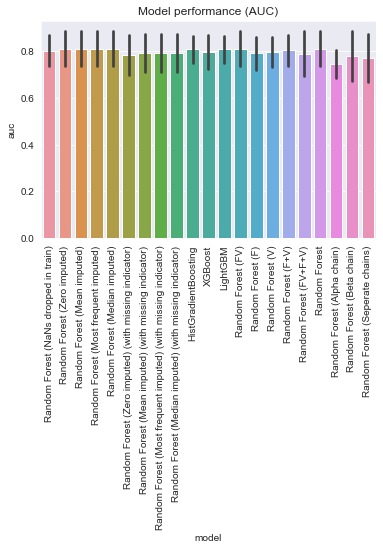

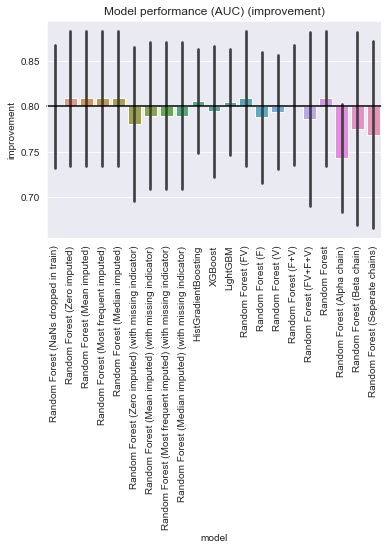

In [43]:
scores = evaluate_model_list(models_to_evaluate)
plot_scores(scores, "Model performance (AUC)")


Evaluating model 1/4
{'name': 'Random Forest', 'model': RandomForestClassifier(random_state=0), 'chain': 'both', 'group': 'chain_inputs'}
0.8844444444444444
0.7352941176470588
0.8533834586466166
0.8782051282051282
0.7087912087912087

Evaluating model 2/4
{'name': 'Random Forest (Alpha chain)', 'model': RandomForestClassifier(random_state=0), 'chain': 'alpha', 'group': 'chain_inputs'}
0.74
0.6970588235294118
0.7481203007518797
0.8557692307692308
0.6895604395604396

Evaluating model 3/4
{'name': 'Random Forest (Beta chain)', 'model': RandomForestClassifier(random_state=0), 'chain': 'beta', 'group': 'chain_inputs'}
0.8355555555555556
0.75
0.8496240601503757
0.875
0.5824175824175823

Evaluating model 4/4
{'name': 'Random Forest (Seperate chains)', 'model_alpha': RandomForestClassifier(random_state=0), 'model_beta': RandomForestClassifier(random_state=0), 'chain': 'seperate', 'group': 'chain_inputs'}
0.8266666666666667
0.7176470588235294
0.8345864661654135
0.8846153846153846
0.596153846153

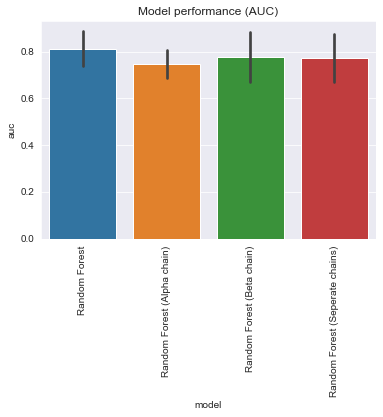

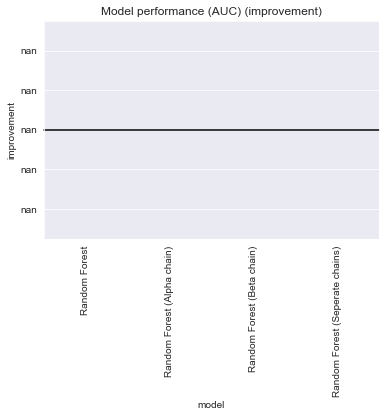

In [44]:
model_sublist = [baseline] + chain_input_models
scores = evaluate_model_list(chain_input_models)
plot_scores(scores, "Model performance (AUC)")